# MAF vs credible set size

The goal of this analysis is to see the correlation between MAF and credible set size

In [ ]:
import random

import matplotlib.pyplot as plt
import polars as pl
import seaborn as sns
from scipy.stats import linregress


In [3]:
random.seed(42)
sns.set_style("white")
sns.set_context("paper", font_scale=1.0)
sns.set_palette(sns.color_palette("rocket"))


In [4]:
dataset = pl.read_parquet("rescaled-beta.parquet")


In [27]:
def bucketizer(col: pl.Expr, buckets: list[int] | list[float]) -> pl.Expr:
    """Perform bucketing of the column."""
    expr = pl.when(False).then(None)
    for idx, bct in enumerate(buckets):
        if idx < len(buckets) - 1:
            expr = expr.when((col >= buckets[idx]) & (col < buckets[idx + 1])).then(bct)
    expr = expr.otherwise(buckets[-1])
    return expr


def bucketizer2(col: pl.Expr, ranges: list[tuple[int, int]]) -> pl.Expr:
    """Perform bucekting at specific ranges."""
    expr = pl.when(False).then(None)
    for idx, range_ in enumerate(ranges):
        assert len(range_) == 2
        assert range_[0] <= range_[1]
        if range_[0] == range_[1]:
            range_name = f"{range_[0]}"
            expr = expr.when(col == range_[0]).then(pl.lit(range_name))
        else:
            if idx != 0 and idx != len(ranges) - 1:
                # lower bound of current range does not overlap with upper bound of left range
                assert ranges[idx][0] != ranges[idx - 1][1]
                # upper bound of current range does not overlap with lower bound of right range
                assert ranges[idx][1] != ranges[idx + 1][1]
            range_name = f"{range_[0]}-{range_[1]}"
            expr = expr.when(((col >= range_[0]) & (col <= range_[1]))).then(pl.lit(range_name))

    return expr


def bucketize_credible_sets_by_size(col: pl.Expr, ranges: list[int] | None = None) -> pl.Expr:
    """Bucketize the credible sets by size."""
    if not ranges:
        ranges = [(1, 1), (2, 5), (6, 10), (11, 20), (21, 50), (51, 100), (101, 100000)]
    return bucketizer2(col, ranges).alias("credibleSetSizeBucket")


In [46]:
data = dataset.select("*", bucketize_credible_sets_by_size(pl.col("credibleSetSize")))
data.select("credibleSetSizeBucket").group_by("credibleSetSizeBucket").agg(pl.len().alias("count")).select(
    pl.col("credibleSetSizeBucket").str.split("-").list.get(0).cast(pl.Int16()).alias("order"),
    pl.col("credibleSetSizeBucket"),
    pl.col("count"),
    (pl.col("count") / pl.col("count").sum() * 100).round(2).alias("%"),
).sort(pl.col("order")).drop("order")


credibleSetSizeBucket,count,%
str,u32,f64
"""1""",506081,19.31
"""2-5""",579268,22.1
"""6-10""",354950,13.54
"""11-20""",391920,14.95
"""21-50""",459504,17.53
"""51-100""",211495,8.07
"""101-100000""",117830,4.5


### Credible set size distributions for each group

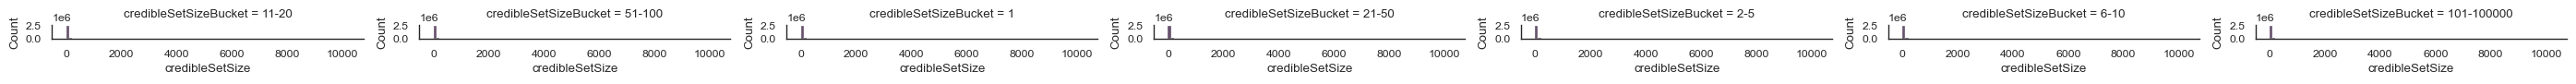

In [71]:
data = dataset.select("*", bucketize_credible_sets_by_size(pl.col("credibleSetSize"))).select(
    pl.col("credibleSetSize"), pl.col("credibleSetSizeBucket")
)
order = ["1", "2-5", "6-10", "11-20", "21-50", "51-100", "101-100000"]
fig = sns.FacetGrid(data=data, col="credibleSetSizeBucket", height=1, aspect=4, sharex=False, sharey=False)

fig.map(
    sns.histplot,
    data=data,
    x="credibleSetSize",
    bins=100,
    # kind="ecdf",
)


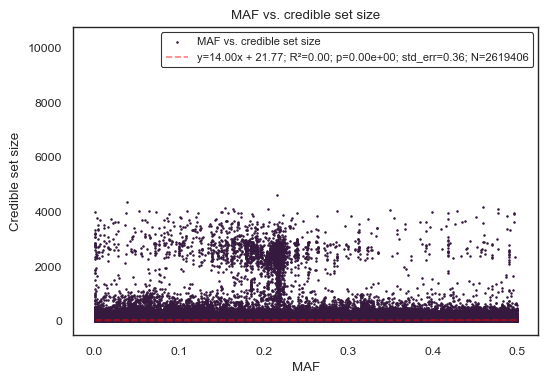

In [ ]:
# plot est beta vs maf

data = dataset.select(
    pl.col("majorPopulationMAF"),
    pl.col("credibleSetSize"),
    pl.col("studyType"),
).filter(pl.col("majorPopulationMAF").is_not_null())
reg = linregress(
    data["majorPopulationMAF"],
    data["credibleSetSize"],
)
slope, intercept, r_value, p_value, std_err = reg
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(
    x=data["majorPopulationMAF"],
    y=data["credibleSetSize"],
    label="MAF vs. credible set size",
    s=1,
)
line_eq = f"y={slope:.2f}x + {intercept:.2f}"
line_eq += f"; R²={r_value**2:.2f}"
line_eq += f"; p={p_value:.2e}"
line_eq += f"; std_err={std_err:.2f}"
line_eq += f"; N={data.shape[0]}"

ax.plot(
    data["majorPopulationMAF"],
    slope * data["majorPopulationMAF"] + intercept,
    "--",
    color="red",
    alpha=0.5,
    label=line_eq,
)

ax.set_title("MAF vs. credible set size")
ax.set_xlabel("MAF")
ax.set_ylabel("Credible set size")
ax.legend(
    loc="upper right",
    fontsize=8,
    title_fontsize=10,
    frameon=True,
    facecolor="white",
    edgecolor="black",
)
ax.set_ylim(0, 4000)

plt.show()
